#### *Deep Learning with Python* Chapter 6: Deep Learning for Texts and Sequences
##### *Notebook by Jacob Kreider*

*The below code is pulled directly from Deep Learning with Python by Francois Chollet (Manning Publications, 2018). Code comments, notes, and commentary are a mix of mine and the book author's. I will put anything directly from the book in quotes, with the exception of code comments. They might be mine, might be his.*

This chapter covers both RNNs (recurrent neural networks) and 1D convnets (CNNs, hereafter) for text processing and timeseries prediction/classification. 

"
Applications of these algorithms include the following:

* Document classification and timeseries classification, such as identifying the topic of an article or the author of a book
* Timeseries comparisons, such as estimating how closely related two documents or two stock tickers are
* Sequence-to-sequence learning, such as decoding an English sentence into French
* Sentiment analysis, such as classifying the sentiment of tweets or movie reviews as positive or negative
* Timeseries forecasting, such as predicting the future weather at a certain location, given recent weather data"

Example networks in this chapter are: sentiment analysis using the IMDb dataset and temperature forecasting.

### 6.1 Working with text data

The methods we use here are for very basic NLP-- good enough for doc classifiers, author identifications, etc. This doesn't give a deep understanding of text, but does "map the statistical structureof written language" which is enough for our examples here.

As with images, we need to convert the raw text into numeric tensors, by *vectorizing* the text. this can be done by:
* Segmenting the text into words, then transforming each word into a vector
* Segmenting the text into characters, then transforming each character in a vector; or,
* Extract *n-grams* (overlapping groups of multiple consecutive words/characters) and transforming each n-gram into a character

***Tokens***: the different units that text can be broken into (i.e words, characters, or n-grams)

***Tokenization***: the process of creating these tokens from the text

How to associate vectors with tokens: one-hot encoding and token embedding

*See chapter section for a detailed explanation of how n-gram tokenization works.* But, one thing to remember is that bag-of-words models (the term for using n-gram tokenization) doesn't preserve word order overall. It just creates a set of the n-gram combinations. As such, it is better for shallow language processing than deep learning. Bag-of-words is a step of *feature engineering*, which deep learning tries to minimize and handle on its own.

#### 6.1.1 One-hot encoding of words and characters

Most common way to turn a token into a vector. Associates a unique integer index with every word, then creating a binary vector with size N = to the size of the vocabulary with all zeros except for a 1 in the *i*th entry.

Let's give it a shot:





In [3]:
# Listing 6.1 Word-level one-hot encoding (toy example)

import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenIndex = {} # Empty index for all the tokens in samples
for sample in samples:
    for word in sample.split(): # splits apart all the words. Could also remove puncuation/common words
        if word not in tokenIndex:
            tokenIndex[word] = len(tokenIndex) + 1 # assigns an index at each word, ignores index[0]
            
maxLength = 10 # This limits the length of the vector. So, here, only first 10 words of each sample are used

# Create a place to store the results
results = np.zeros(shape = (len(samples)
                            , maxLength
                           , max(tokenIndex.values()) + 1))

# one-hot encode the tokenIndex

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:maxLength]:
        index = tokenIndex.get(word)
        results[i, j, index] = 1.


In [4]:
# Listing 6.2 Character-level one-hot encoding (toy example)

import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

characters = string.printable
tokenIndex = dict(zip(range(1, len(characters) + 1), characters))

maxLength = 50

results = np.zeros((len(samples), maxLength, max(tokenIndex.keys()) + 1))

for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = tokenIndex.get(character)
        results[i, j, index] = 1.

We can use keras' built-in one-hot encoding. It strips out special characters and only considers the N most common words in the data (a commonly used restriction)

In [5]:
# Listing 6.3 Using Keras for word-level one-hot encoding

from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

oneHotResults = tokenizer.texts_to_matrix(samples, mode = 'binary')

wordIndex = tokenizer.word_index
print('Found %s unique tokens.' % len(wordIndex))

Found 9 unique tokens.


For data where the number of unique tokens is extremely large, we can use *one-hot hashing trick* which hashes words into vectors of fixed size, rather than assigning an index to each.

To avoid having multiple words assigned to the same has (called *hash collisions*), the dimensionality of the hashing space should be much larger than the total number of unique tokens.

In [6]:
# Listing 6.4 Word-level one-hot encoding with hashing trick

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000 # if we had close to 1K words, there'd be a ton of hash collisions
maxLength = 10

results = np.zeros((len(samples), maxLength, dimensionality))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:maxLength]:
        index = abs(hash(word)) % dimensionality # hashes the word into random in b/w 1 and 1000
        results[i, j, index] = 1.

#### 6.1.2 Using word embeddings

One-hot encoding creates *binary, sparse, and high dimensional* vectors, word embeddings are low-dimensional floating-point vectors (i.e. dense vectors). In essence, word embeddings "pack more information into far fewer dimensions."

Two ways to obtain:

1) "Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network."

2) "Load into your model word embeddings that were precomputed using a different machine-learning task than the one you’re trying to solve. These are called *pretrained word embeddings*."

###### Learning word embeddings with the Embedding Layer

The geometric relationships between words should refelct the semantic relationships. For example, "accurate" and "exact" should be similarly embedded. So, we should account for both geometric distance (as in *exact* and *precise*), as well as direction (as in *cat* to *tiger*).

When done correctly, we should be able to make meaningful transformations (e.g. adding *female* to *king* == *queen*). This is obviously very task dependent. So, it makes sense to learn a new embedding space with each new task, and this can be done relatively easily, thanks to our old friend backpropagation.



In [7]:
# List 6.5 Instantiating an Embedding Layer with keras

from keras.layers import Embedding

embeddingLayer = Embedding(1000, 64)

We can think of the embedding layer as "a dictionary that maps integer indices (which stand for specific words) to dense vectors...it is effectively a dictionary lookup."

Word Index ------> Embedding Layer -----> Corresponding word vector

The Embedding Layer takes a 2D tensor of integers as input (shape = (samples, sequenceLength)). Because they get packed into a single tensor, shorter sequences should be padded with zeros and longer ones should be truncated (if need be, depending on batch size).

The Embedding Layer returns a 3D floating-point tensor of shape(samples, sequenceLength, embeddingDimensionality), which can then be processed by RNNs and 1D CNNs.

When an Embedding Layer is instantiated, as above, it starts with random weights, and then they are adjusted via backprop, just like a normal network.

Now, we'll apply this to the IMDb data:

In [8]:
# Listing 6.6 Loading the IMDb data for use with Embedding Layer

from keras.datasets import imdb
from keras import preprocessing

# Set the number of words to consider as features
maxFeatures = 10000
# Cuts off the text after this number of words
maxlen = 20

(xTrain, yTrain), (xTest, yTest) = imdb.load_data(
    num_words = maxFeatures)

# Turn the list of integers into a 2D integer tensor, shape(samples, maxlen)
xTrain = preprocessing.sequence.pad_sequences(xTrain, maxlen = maxlen)
xTest = preprocessing.sequence.pad_sequences(xTest, maxlen = maxlen)

In [9]:
# Listing 6.7 Using an Embedding LAyer and classifier on the IMDb data

from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# Sepcify the max inout length to the Embed layer,so we can flatten the inputs later
# Activations after this layer wil have shae(samples, maxlen, 8)
model.add(Embedding(10000, 8, input_length = maxlen))

# Flatten the 3D tensor output from the Embedding layer into
# a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())

# Now, we'll add the classifier
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

history = model.fit(xTrain, yTrain
                   , epochs = 10
                   , batch_size = 32
                   , validation_split = 0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 94us/step - loss: 0.6759 - acc: 0.6049 - val_loss: 0.6398 - val_acc: 0.6812
Epoch 2/10
20000/20000 [==============================] - 2s 92us/step - loss: 0.5658 - acc: 0.7426 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 2s 76us/step - loss: 

The really basic model above gave us ~75% accuracy. Pretty good, considering we were only looking at the first 20 words in each review.

What it *didn't* do was account for any inter-word relationships. It saw all words as standalone. Adding recurrent or 1D convolutional layers on top will help learn features that account for the meanings of sequences of words.

###### Using pretrained word embeddings

IF you don't have enough data to learn the embedding space on your own, you can download highly structured, pretrained word embeddings. Some example of these pretraining embedding spaces are Word2Vec and GloVe.

#### 6.1.3 Putting it all together: from raw text to word embeddings

Start this section by downloading and installing the raw IMDb dataset from [here](http://mng.bz/0tIo) . Change path in Listing 6.8 to local directory.

In [10]:
# Listing 6.8 Processing the labels of the raw IMDb data

import os
imdbDir = '/home/jacob/MSDS-git/msds458/Data/imdb/aclImdb'
trainDir = os.path.join(imdbDir, 'test')

labels = []
texts = []

# Pull in data from 'pos' and 'neg' directories and label each review file as such
for label_type in ['neg', 'pos']:
    dirName = os.path.join(trainDir, label_type)
    for fname in os.listdir(dirName):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dirName, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)



In [11]:
# Now, we'll vectorize the text and create training and validation
# sets. We'll also restrict to 200 samples (since the point of
# using pretrained embeddings is because you have limited samples)

# Listing 6.9 Tokenizing the test of the raw IMDb data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # only uses first 100 words
trainingSamples = 200 # only trains on 200 samples
validationSamples = 10000 # validates on 10K samples
maxWords = 10000 # uses only top 10K words

tokenizer = Tokenizer(num_words = maxWords)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

wordIndex = tokenizer.word_index
print('Found %s unique tokens.' % len(wordIndex))

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices) # shuffle the data so it isn't ordered positive to negative
data = data[indices]
labels = labels[indices]

xTrain = data[:trainingSamples]
yTrain = labels[:trainingSamples]
xVal = data[trainingSamples: trainingSamples + validationSamples]
yVal = labels[trainingSamples: trainingSamples + validationSamples]

Found 72633 unique tokens.
Shape of data tensor: (17243, 100)
Shape of label tensor: (17243,)


###### Download GloVe word embeddings

Go [here](https://nlp.stanford.edu/projects/glove) and download the zip file glove.6B.zip. Unzip it, we'll be using the glove.6B.100d.txt file.

Change the path below to reflect where it's stored.

In [12]:
# Listing 6.10 Parsing the GloVe word-embeddings file

gloveDir = '/home/jacob/MSDS-git/msds458/Data/glov'

embeddingsIndex = {}
f = open(os.path.join(gloveDir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddingsIndex[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddingsIndex))

Found 400000 word vectors.


In [13]:
# Next, we build an embedding matrix that we can pass to
# the embedding layer. 

# Listing 6.11 Preparing the GloVe word embeddings matrix

embeddingDim = 100

embeddingMatrix = np.zeros((maxWords, embeddingDim))

for word, i in wordIndex.items():
    if i < maxWords:
        embeddingVector = embeddingsIndex.get(word)
        if embeddingVector is not None:
            embeddingMatrix[i] = embeddingVector

###### Defining a model

We'll use the same architecture we did in the last section

In [14]:
# Listing 6.12 Model Definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(maxWords, embeddingDim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Listing 6.13 Loading pretrained word embeddings into the Embedding layer

model.layers[0].set_weights([embeddingMatrix])
model.layers[0].trainable = False

We set the trainable parameter to false above because these are pretrained weights...we don't want the model forgetting what it already knows by updating these weights.

###### Training and evaluating the model:

In [16]:
# Listing 6.14 Training and evaluation

model.compile(optimizer = 'rmsprop'
             , loss = 'binary_crossentropy'
             , metrics = ['acc'])
history = model.fit(xTrain, yTrain
                   , epochs = 10
                   , batch_size = 32
                   , validation_data = (xVal, yVal))
model.save_weights('pretrainedGloveModel.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 1.9447 - acc: 0.5500 - val_loss: 1.1285 - val_acc: 0.7243
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4946 - acc: 0.7450 - val_loss: 0.7485 - val_acc: 0.7243
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2930 - acc: 0.8800 - val_loss: 0.6088 - val_acc: 0.6927
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3643 - acc: 0.8250 - val_loss: 0.7008 - val_acc: 0.5553
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1540 - acc: 0.9750 - val_loss: 0.6687 - val_acc: 0.7250
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0926 - acc: 0.9900 - val_loss: 0.6451 - val_acc: 0.6449
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0543 - acc: 1.0000 - val_loss: 1.0784 - val_acc: 0.7245
Epoch 8/10
200/200 [========

In [17]:
# Listing 6.15 Plotting the results

import matplotlib.pyplot as plt

acc = history.history['acc']
valAcc = history.history['val_acc']
loss = history.history['loss']
valLoss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, valAcc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, valLoss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Crazy overfitting, due to the tiny number of training samples. In the book, he re-runs the model without the pretrained embeddings, and unsurprisingly gets much worse validation accuracy. I won't re-create here, as that's pretty intuitive.

#### 6.1.4 Wrapping up

In this section, we learned to:
* Turn raw text into tensors that a neural network can ingest
* Use *Embedding* layers in keras to learn token embeddings
* Use pretrained word embeddings in cases where we don't have much data to pass to NLP problems

### 6.2 Understanding recurrent neural networks

CNNs and Dense networks have no *memory*-- each input is processed independently, with no preserved state. In these types of models, squences and time series would need compressed to a single dimensional input.

To get a "fluid representation of the meaning," we need to not only process current state, we need to preserve memory of what came before. *Recurrent neural networks* (RNNs) do a simplified version of "processing information incrementally while maintaining an internal model of what it's processing, built from past information and constantly updated as new information comes in."

How do they do this? RNNs process squences by iterating through the squence elements and maintaining a *state* containing information relative to what they have seen thus far. Basically, it is a netowrk that contains an *internal loop*. Between two independent sequences, the state is reset-- so, it is still considering one sequence a single input. The input, however, is no longer processed in a single step-- the network loops over seuqence elements.

To make these ideas of *loops* and *states* easier to envision, we'll use some pseduocode:

In [18]:
# This code isn't going to actually run

# Listing 6.19 Pseudocode RNN
stateT = 0
for inputT in inputSequence: # to iterate over elements in the sequence
    outputT = f(inputT, stateT) 
    stateT = outputT # the output becomes the state for the next iteration

# Let's flesh out the pseudocode a bit

# Listing 6.20 More detailed pseudocode for the RNN
stateT = 0
for inputT in inputSequence:
    outputT = activation(dot(W, inputT) + dot(U, stateT) + b)
    stateT = outputT



NameError: name 'inputSequence' is not defined

In [19]:
# Let's build an actual, simple implementation

# Listing 6.21 Numpy implementation of a simple RNN

import numpy as np

timesteps = 100 # number of timesteps in input sequence
inputFeatures = 32 # dimensionality of the input feature space
outputFeatures = 64 # dimensionality of the output feature space

inputs = np.random.random((timesteps, inputFeatures)) # this is just random noise as an example

stateT = np.zeros((outputFeatures, )) # initial state (all zero vector)

# We'll create some random weight matrices
W = np.random.random((outputFeatures, inputFeatures))
U = np.random.random((outputFeatures, outputFeatures))
b = np.random.random((outputFeatures, ))

successiveOutputs = []
for inputT in inputs:
    # We'll combine the input with the previous output to get a new current output
    outputT = np.tanh(np.dot(W, inputT) + np.dot(U, stateT) + b)
    # Store the above output in a list
    successiveOutputs.append(outputT)
    # Sets the new state (for next iteration) as the current (this iteration) output
    stateT = outputT
# The final output is a 2D tensor of shape(timesteps, outputFeatures)    
finalOutputSequence = np.concatenate(successiveOutputs, axis = 0)

***Note***: *In a lot of cases, you don't need to worry about all the output sequences, just the last one-- it contains all the information about the entire sequence

#### 6.2.1 A recurrent layer in keras

from keras.layers import SimpleRNN corresponds to the above code.

When using keras, however, it processes sequence batches, not single sequences as above. So, the input has shape(batch_size, timesteps, input_features).

With this and all keras recurrent layers, you can either return the full sequences of successive outputs, as done in numpy above, or just the last output for each input sequence. ***return_sequences** argument handles this.

The next code uses SimpleRNN and returns only the output at the last timestep:

In [20]:
# SimpleRNN in keras


from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32)) # the default is to return only final output
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [21]:
# To return full state sequence:

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences = True)) # Set return_sequences to True
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


***Note***: If using multiple recurrent layers, each intermediate layer *must* return the full sequence of outputs:

In [23]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now, we'll prepare the keras IMDb data via preprocessing

In [25]:
# Listing 6.22 Preparing the IMDb data

from keras.datasets import imdb
from keras.preprocessing import sequence

maxFeatures = 10000
maxlen = 500
batchSize = 32

print('Loading data...')
(inputTrain, yTrain), (inputTest, yTest) = imdb.load_data(
    num_words = maxFeatures)
print(len(inputTrain), 'train sequences')
print(len(inputTest), 'test sequences')

print('Pad sequences (samples x time)')

inputTrain = sequence.pad_sequences(inputTrain, maxlen = maxlen)
inputTest = sequence.pad_sequences(inputTest, maxlen = maxlen)

print('input train shape:' , inputTrain.shape)
print('input test shape:', inputTest.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input train shape: (25000, 500)
input test shape: (25000, 500)


In [27]:
# Now, we'll train a simple RNN with an Embedding and a SimpleRNN layer

# Listing 6.23 Training the model with Embedding and SimpleRNN layers

from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential

model = Sequential()
model.add(Embedding(maxFeatures, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop'
             , loss = 'binary_crossentropy'
             , metrics = ['acc'])

history = model.fit(inputTrain, yTrain
                   , epochs = 10
                   ,batch_size = 128
                   , validation_split = 0.2)



Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.6439 - acc: 0.6096 - val_loss: 0.4864 - val_acc: 0.7960
Epoch 2/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.4076 - acc: 0.8236 - val_loss: 0.4076 - val_acc: 0.8314
Epoch 3/10
20000/20000 [==============================] - 30s 1ms/step - loss: 0.2852 - acc: 0.8868 - val_loss: 0.4386 - val_acc: 0.8030
Epoch 4/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.2374 - acc: 0.9060 - val_loss: 0.4198 - val_acc: 0.8238
Epoch 5/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1684 - acc: 0.9380 - val_loss: 0.3923 - val_acc: 0.8462
Epoch 6/10
20000/20000 [==============================] - 30s 1ms/step - loss: 0.1186 - acc: 0.9580 - val_loss: 0.4138 - val_acc: 0.8620
Epoch 7/10
20000/20000 [==============================] - 30s 1ms/step - loss: 0.0812 - acc: 0.9733 - val_loss: 0.4879 - val_acc:

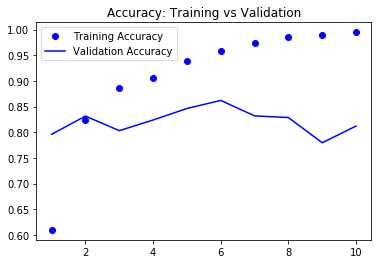

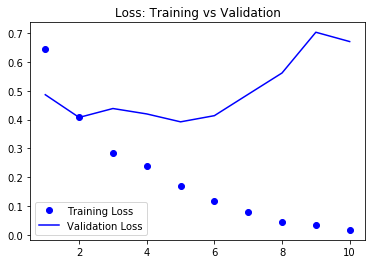

In [28]:
# Display the training and validation loss accuracy

import matplotlib.pyplot as plt

acc = history.history['acc']
valAcc = history.history['val_acc']
loss = history.history['loss']
valLoss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = "Training Accuracy")
plt.plot(epochs, valAcc, 'b', label = 'Validation Accuracy')
plt.title("Accuracy: Training vs Validation")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, valLoss, 'b', label = 'Validation Loss')
plt.title("Loss: Training vs Validation")
plt.legend()

plt.show()

Our network here underperforms compared to our network in Section 2.1. From the book:

"Part of the problem is that your inputs only consider the first 500 words, rather than full sequences—hence, the RNN has access to less information than the earlier baseline model. The remainder of the problem is that SimpleRNN isn’t good at processing long sequences, such as text. Other types of recurrent layers perform much better. Let’s look at some more-advanced layers."

#### 6.2.2 Understanding the LSTM and GRU layers

In addition to SimpleRNN, keras also includes LSTM and GRU layers for RNNs. SimpleRNN can't actually learn long-term dependencies due to the *vanishing gradient problem*.

***The vanishing gradient problem***: as you keep adding layers to the network, the network eventually becomes untraineable. (For the theory behind this, see Yoshua Bengio, Patrice Simard, and Paolo Frasconi, “Learning Long-Term Dependencies with Gradient Descent Is Difficult,” IEEE Transactions on Neural Networks 5, no. 2 (1994).)

The LSTM and GRU layers are designed to solve this issue.

###### LSTM Layer

LSTM stands for *Long Short-Term Memory* algorithm (see Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory,” Neural Computation 9, no. 8 (1997).). LSTM essentially works as a "conveyor belt" that sequence info can jump onto, preserving it for later use and protecting the signals from gradually vanishing during processing. See the book for helpful diagrams showing the process.

So, where the SimpleRNN used the ouput of the current sequence as the state for the next sequence, the LSTM creates a "carry" values (Ct) that combines with the input and recurrent connections at each cell to affect that state as it's sent to the next timestamp.

It does this via three transformations, all of which work like SimpleRNN layers, but with distinct weight matrices (i, f, and k).

So, in pseudo code:

###### Listing 6.25 Pseudocode details of the LSTM architecture (1/2)
outputT = activation(dot(stateT, Uo) + dot(inputT, Wo) + dot(Ct, Vo) + bo)
(Below, index i, f, and k are the weight matrices for each of the three transformation):
i_t = activation(dot(stateT, Ui) + dot(inputT, Wi) + bi)
f_t = activation(dot(stateT, Uf) + dot(inputT, Wf) + bf)
k_t = activation(dot(stateT, Uk) + dot(inoutT, Wk) + bk)

The new carro state (the next Ct) can be obtained by combining i_t, f_t, and k_t:

###### Listing 6.26 Pseudocode details of the LSTM architecture (2/2)
Ct+1 = i_t * k_t + Ct * f_t (<-- i_t*k_t provide info about the present state that gets updated in the new carry track, while Ct*f_t "forgets" irrelevant info and removes it from the new state)

Add the new Ct before the next input sequence and you're good to go.

There's not really a way to understand specifically what the relationships here are, the main thing to know is that ***LSTM cells allow past information to be injected at a later time, thus fighting the vanishing gradient problem***

#### 6.2.3 A concrete LSTM example in Keras

We'll train an LSTM on the IMDb data. It looks similar to the SimpleRNN. There are many parameters to set, but the keras defaults are good in most cases. 

Let's see what it looks like:






In [ ]:
# Listing 6.27 Using the LSTM layer in keras

from keras.layers import LSTM

model = Sequential()
model.add(Embedding(maxFeatures, 32))
model.add(LSTM(32))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop'
             , loss = 'binary_crossentropy'
             , metrics = ['acc'])
history = model.fit(inputTrain, yTrain
                   , epochs = 10
                   ,batch_size = 128
                   , validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 103s 5ms/step - loss: 0.5116 - acc: 0.7647 - val_loss: 0.4128 - val_acc: 0.8472
Epoch 2/10
20000/20000 [==============================] - 97s 5ms/step - loss: 0.2962 - acc: 0.8835 - val_loss: 0.6159 - val_acc: 0.8426
Epoch 3/10
20000/20000 [==============================] - 98s 5ms/step - loss: 0.2411 - acc: 0.9099 - val_loss: 0.2998 - val_acc: 0.8872
Epoch 4/10
20000/20000 [==============================] - 98s 5ms/step - loss: 0.1987 - acc: 0.9271 - val_loss: 0.4237 - val_acc: 0.8576
Epoch 5/10
20000/20000 [==============================] - 325s 16ms/step - loss: 0.1741 - acc: 0.9370 - val_loss: 0.2972 - val_acc: 0.8720
Epoch 6/10
20000/20000 [==============================] - 100s 5ms/step - loss: 0.1520 - acc: 0.9448 - val_loss: 0.3434 - val_acc: 0.8824
Epoch 7/10
 7936/20000 [==========>...................] - ETA: 1:03 - loss: 0.1275 - acc: 0.9592

In [ ]:
# Creating plots

import matplotlib.pyplot as plt

acc = history.history['acc']
valAcc = history.history['val_acc']
loss = history.history['loss']
valLoss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = "Training Accuracy")
plt.plot(epochs, valAcc, 'b', label = 'Validation Accuracy')
plt.title("Accuracy: Training vs Validation")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, valLoss, 'b', label = 'Validation Loss')
plt.title("Loss: Training vs Validation")
plt.legend()

plt.show()

Validation accuracy rises to ~89%. LSTM suffers less from the vanishing graident problem than the SimpleRNN. But, why didn't it do better?

* We didn't try and tune the hyperparameters at all
* Maybe lack of regularization
* But, mainly, this type of problem is better solved by looking at word frequencies. Long-term structure of the reviews (that we're doing here) isn't as helpful as just using fully-connected layers.

LSTM really shines at things like question-and-answering and machine translation.

#### 6.2.4 Wrapping up

We've covered:

* What RNNs are and how they work
* What LSTM is and why it works well on long sequences
* How to use keras RNN layers to process sequence data